# Indice: 
**Parte 1:** 
- Conexión a la API de YELP

**Parte 2:**
- Carga de datos
- Exploración inicial
- Descripción de los datos (API Yelp - restaurantes):

- Elaboración de rating de mejores restaurant para recomendar.
    1. Análisis de las variables relevantes
    2. Elaboración de rating ponderado.
    3. Revisión del rating ponderado
    4. Reajuste: nuevo rating
    5. Revisión de nuevo rating.

## **Parte 1:** 
### Conexión a la API de YELP

In [ ]:
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast #usada para extraer categoría del restaurant 

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
#url de la API: Endpoint principal de Yelp
api_url='https://api.yelp.com/v3/businesses/search'

#estos datos corresponden a una cuenta de usuario creada previamente
clientid='tu_id'
apikey='tu_key'
headers={'Authorization':'Bearer %s'%apikey}

In [4]:
ciudad = "Miami" # Ciudad elegida

In [ ]:
# Lista vacía para guardar resultados: 

todos_resultados = []

# En 2025, Yelp permite hasta 200 resultados (page no existe en Yelp; se pagina con offset)
for offset in [0, 50, 100, 150]: # hago request de a 50.
    params = {
        "term": "restaurants",
        "location": ciudad,
        "limit": 50,
        "offset": offset
    }
    #hacemos request:
    response = requests.get(api_url, params=params, headers=headers)

    #si hay error, corta:
    if response.status_code != 200:
        print(f"Error en request (offset={offset}):", response.json())
        break

    #sino, convierte response a json
    data = response.json()
    negocios = data.get("businesses", []) #toma businesses (lista de negocios) que es lo que nos interesa 
    
    if not negocios:  # si ya no hay más resultados, corto el loop
        break
    
    todos_resultados.extend(negocios)

print(f"Total resultados descargados: {len(todos_resultados)}")



Total resultados descargados: 200


In [ ]:
# Convertir a DataFrame
df = pd.json_normalize(todos_resultados)
print(df.head())


                       id                                   alias  \
0  K3ukx2e11xTRtYBU01dmrA                       salty-flame-miami   
1  ix8ifP1jQM9ektdVAs19sQ                 crazy-about-you-miami-3   
2  UXHxLN3DcDGI57uDIfCuJA  olds-havana-cuban-bar-and-cocina-miami   
3  oxtMfBGmVNE18pFVuw7lFg               fratellino-coral-gables-2   
4  WqIBKxRUPXH3NqTViAHLxQ       bayshore-club-bar-and-grill-miami   

                              name  \
0                      Salty Flame   
1                  Crazy About You   
2  Old's Havana Cuban Bar & Cocina   
3                       Fratellino   
4        Bayshore Club Bar & Grill   

                                           image_url  is_closed  \
0  https://s3-media0.fl.yelpcdn.com/bphoto/_6wShT...      False   
1  https://s3-media0.fl.yelpcdn.com/bphoto/vvQBoP...      False   
2  https://s3-media0.fl.yelpcdn.com/bphoto/OyMD-x...      False   
3  https://s3-media0.fl.yelpcdn.com/bphoto/OPS9ib...      False   
4  https://s3-media0.

In [ ]:
#Veamos los keys del diccionario recibido (businesses es la que ya tomamos que tenía la data)
data.keys()

dict_keys(['businesses', 'total', 'region'])

In [ ]:
#El segundo elemento del diccionario [total] indica el total de restaurants existentes en la API
total_restaurants = data['total']  # data es la última request, pero 'total' es siempre el total global

total_bajado = len(todos_resultados)

# porcentaje descargado
porc_descargado = (total_bajado / total_restaurants) * 100

print(f'Se descargaron {total_bajado} de {total_restaurants} restaurants de {ciudad} en la base de Yelp ({porc_descargado:.1f}%)')


Se descargaron 200 de 5600 restaurants de Miami en la base de Yelp (3.6%)


In [ ]:
# Guardo en CSV

df.to_csv("yelp_restaurantes_miami.csv", index=False)

Este script solo lo corremos una vez. Para los análisis levantaremos el csv creado

### **PARTE 2:** 

- Abro base recién generada
- Descripción de variables obtenidas de Yelp.  
- Identificación de duplicados.  
- Análisis de calidad de datos y tratamiento de valores nulos.  
- Creación de un rating ponderado, ajustado por cantidad de reseñas.  
- Elaboración del ranking de mejores restaurantes.  
- Análisis de categorías de restaurantes.


In [ ]:
ruta = 'yelp_restaurantes_miami.csv'
df= pd.read_csv(ruta) # Cargamos el DataFrame creado en request
df_res = df.copy() # Creamos una copia del DataFrame original para trabajar con él sin modificarlo

In [ ]:
print(f'El DataFrame tiene {df_res.shape[0]} filas y {df_res.shape[1]} columnas.') # 0 para filas, 1 para columnas

El DataFrame tiene 200 filas y 24 columnas.


In [ ]:
df_res.head()

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,transactions,...,coordinates.longitude,location.address1,location.address2,location.address3,location.city,location.zip_code,location.country,location.state,location.display_address,price
0,K3ukx2e11xTRtYBU01dmrA,salty-flame-miami,Salty Flame,https://s3-media0.fl.yelpcdn.com/bphoto/_6wShT...,False,https://www.yelp.com/biz/salty-flame-miami?adj...,190,"[{'alias': 'asianfusion', 'title': 'Asian Fusi...",4.4,"['delivery', 'pickup']",...,-80.192670,1414 Brickell Ave,NaN,NaN,Miami,33131.0,US,FL,"['1414 Brickell Ave', 'Miami, FL 33131']",NaN
1,ix8ifP1jQM9ektdVAs19sQ,crazy-about-you-miami-3,Crazy About You,https://s3-media0.fl.yelpcdn.com/bphoto/vvQBoP...,False,https://www.yelp.com/biz/crazy-about-you-miami...,2784,"[{'alias': 'mediterranean', 'title': 'Mediterr...",4.2,"['delivery', 'restaurant_reservation']",...,-80.188986,1155 Brickell Bay Dr,Ste 101,NaN,Miami,33131.0,US,FL,"['1155 Brickell Bay Dr', 'Ste 101', 'Miami, FL...",$$
2,UXHxLN3DcDGI57uDIfCuJA,olds-havana-cuban-bar-and-cocina-miami,Old's Havana Cuban Bar & Cocina,https://s3-media0.fl.yelpcdn.com/bphoto/OyMD-x...,False,https://www.yelp.com/biz/olds-havana-cuban-bar...,2994,"[{'alias': 'cuban', 'title': 'Cuban'}, {'alias...",4.4,"['restaurant_reservation', 'pickup']",...,-80.219238,1442 SW 8th St,NaN,NaN,Miami,33135.0,US,FL,"['1442 SW 8th St', 'Miami, FL 33135']",$$
3,oxtMfBGmVNE18pFVuw7lFg,fratellino-coral-gables-2,Fratellino,https://s3-media0.fl.yelpcdn.com/bphoto/OPS9ib...,False,https://www.yelp.com/biz/fratellino-coral-gabl...,1811,"[{'alias': 'italian', 'title': 'Italian'}]",4.8,"['delivery', 'pickup']",...,-80.260110,264 Miracle Mile,NaN,NaN,Coral Gables,33134.0,US,FL,"['264 Miracle Mile', 'Coral Gables, FL 33134']",$$$
4,WqIBKxRUPXH3NqTViAHLxQ,bayshore-club-bar-and-grill-miami,Bayshore Club Bar & Grill,https://s3-media0.fl.yelpcdn.com/bphoto/B7tTbJ...,False,https://www.yelp.com/biz/bayshore-club-bar-and...,945,"[{'alias': 'seafood', 'title': 'Seafood'}, {'a...",4.3,[],...,-80.234162,3391 Pan American Dr,NaN,NaN,Miami,33133.0,US,FL,"['3391 Pan American Dr', 'Miami, FL 33133']",$$$


In [ ]:
df_res.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        200 non-null    object 
 1   alias                     200 non-null    object 
 2   name                      200 non-null    object 
 3   image_url                 200 non-null    object 
 4   is_closed                 200 non-null    bool   
 5   url                       200 non-null    object 
 6   review_count              200 non-null    int64  
 7   categories                200 non-null    object 
 8   rating                    200 non-null    float64
 9   transactions              200 non-null    object 
 10  phone                     183 non-null    float64
 11  display_phone             183 non-null    object 
 12  distance                  200 non-null    float64
 13  coordinates.latitude      200 non-null    float64
 14  coordinate

### Descripción de los datos (API Yelp - restaurantes):

**Variables de identificación (no relevantes para análisis descriptivo):**

- id: Identificador único del negocio.

- alias: Alias del negocio.

- name: Nombre comercial.

- url: Link a la página del negocio en Yelp.

- image_url: URL de la foto principal del restaurante.

- phone: Número de teléfono en formato numérico (a veces vacío).

- display_phone: Teléfono.

**Variables de estado/actividad:**

- is_closed: Indica si el negocio está cerrado permanentemente. En este dataset son todos False.

- transactions: Lista de tipos de transacciones (ej. delivery, pickup).

**Variables de reseñas y calificaciones:**

- review_count: Número de reseñas registradas en Yelp.

- rating: Rating promedio (1 a 5 estrellas).

- price: Rango de precio estimado ($ a $$$$).

**Variables de localización:**

- coordinates.latitude: Latitud geográfica.
- coordinates.longitude: Longitud geográfica.
- location.address1: Dirección principal.
-location.address2: Dirección secundaria (a veces nula).
-location.address3: Dirección terciaria (casi siempre vacía).
-location.city: Ciudad donde se ubica el restaurante.
-location.state: Estado o región. (En este dataset son todas Miami)
-location.zip_code: Código postal.
-location.country: País.
-location.display_address: Dirección en formato de texto amigable.

**Variables de categorías y distancia:**

- categories: Lista de categorías asignadas al restaurante (ej. Italian, Pizza, Coffee & Tea).

- distance: Distancia en metros desde la ubicación usada en la búsqueda.

In [ ]:
# Descripcion numericas
df_res.describe()

,review_count,rating,phone,distance,coordinates.latitude,coordinates.longitude,location.zip_code
count,200.000000,200.000000,1.830000e+02,200.000000,200.000000,200.000000,199.000000
mean,508.395000,4.316500,1.487015e+10,6095.385653,25.766742,-80.251645,33136.628141
std,840.252079,0.465792,2.365161e+09,3066.864266,0.028471,0.045672,15.150505
min,0.000000,0.000000,1.206696e+10,132.202770,25.687993,-80.393596,33010.000000
25%,71.500000,4.100000,1.305452e+10,3185.533577,25.749846,-80.279949,33131.000000
50%,209.500000,4.400000,1.305688e+10,5519.203454,25.765795,-80.256786,33134.000000
75%,568.750000,4.500000,1.786483e+10,9420.506464,25.781620,-80.211235,33142.000000
max,6884.000000,5.000000,1.954991e+10,13539.614717,25.842900,-80.175702,33183.000000


In [ ]:
# Descripcion no numericas
df_res.describe(exclude= 'number')

,id,alias,name,image_url,is_closed,url,categories,transactions,display_phone,location.address1,location.address2,location.address3,location.city,location.country,location.state,location.display_address,price
count,200,200,200,200,200,200,200,200,183,200,27,4,200,200,200,200,134
unique,200,200,199,200,1,200,171,12,183,195,27,4,10,1,1,199,4
top,K3ukx2e11xTRtYBU01dmrA,salty-flame-miami,First Watch,https://s3-media0.fl.yelpcdn.com/bphoto/_6wShT...,False,https://www.yelp.com/biz/salty-flame-miami?adj...,"[{'alias': 'italian', 'title': 'Italian'}]",[],(305) 563-8972,2600 NW 87th Ave,Ste 101,Coral Gables Golf & Country Club,Miami,US,FL,"['3555 SW 8th St', 'Miami, FL 33135']",$$
freq,1,1,2,1,200,1,7,70,1,2,1,1,147,200,200,2,92


Las variables relevantes para el análisis serán reseñas, calificaciones, precios, categoría.  También es interesante analizar lo relativo a transactions y coordenadas geográficas.



### Identificación de duplicados

In [ ]:
#identificar id duplicados

print('Cantidad de id duplicados:', df_res.duplicated(['id']).sum())
print('Cantidad de id con valores únicos:', df_res['id'].nunique())

print('Cantidad de alias duplicados:', df_res.duplicated(['alias']).sum())
print('Cantidad de alias con valores únicos:', df_res['alias'].nunique())

print('Cantidad de nombre restaurant duplicados:', df_res.duplicated(['name']).sum())
print('Cantidad de nombre restaurant con valores únicos:', df_res['name'].nunique())

Cantidad de id duplicados: 0
Cantidad de id con valores únicos: 200
Cantidad de alias duplicados: 0
Cantidad de alias con valores únicos: 200
Cantidad de nombre restaurant duplicados: 1
Cantidad de nombre restaurant con valores únicos: 199


In [ ]:
# Solo un duuplicado en nombre. No parece problemático, pero lo vemos:

df_res[(df_res.duplicated(['name'])>0)]

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,transactions,...,coordinates.longitude,location.address1,location.address2,location.address3,location.city,location.zip_code,location.country,location.state,location.display_address,price
127,rOSY396xA0wV4AzgZ-MS0g,first-watch-doral,First Watch,https://s3-media0.fl.yelpcdn.com/bphoto/pcDhGc...,False,https://www.yelp.com/biz/first-watch-doral?adj...,185,"[{'alias': 'breakfast_brunch', 'title': 'Break...",4.2,[],...,-80.33655,3737 NW 87th Ave,Ste 108,NaN,Doral,33166.0,US,FL,"['3737 NW 87th Ave', 'Ste 108', 'Doral, FL 331...",$$


In [ ]:
df_res[df_res['name'] == 'First Watch']

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,transactions,...,coordinates.longitude,location.address1,location.address2,location.address3,location.city,location.zip_code,location.country,location.state,location.display_address,price
7,4GKmQ1rynV5RUSiaHHenWQ,first-watch-miami-6,First Watch,https://s3-media0.fl.yelpcdn.com/bphoto/lPn0xh...,False,https://www.yelp.com/biz/first-watch-miami-6?a...,499,"[{'alias': 'breakfast_brunch', 'title': 'Break...",3.9,[],...,-80.29053,5799 NW 7th St,NaN,NaN,Miami,33125.0,US,FL,"['5799 NW 7th St', 'Miami, FL 33125']",$$
127,rOSY396xA0wV4AzgZ-MS0g,first-watch-doral,First Watch,https://s3-media0.fl.yelpcdn.com/bphoto/pcDhGc...,False,https://www.yelp.com/biz/first-watch-doral?adj...,185,"[{'alias': 'breakfast_brunch', 'title': 'Break...",4.2,[],...,-80.33655,3737 NW 87th Ave,Ste 108,NaN,Doral,33166.0,US,FL,"['3737 NW 87th Ave', 'Ste 108', 'Doral, FL 331...",$$


Vemos que el único caso que tiene el mismo nombre tiene otra ubicación, así que es correcto: No hay duplicados.

### Calidad de los datos:

Locación ciudad: Se verificó que las ciudades que no son Miami son municipios, barrios o suburbios cercanos, dentro del condado de Miami-Dade. Todas están dentro del área metropolitana de Miami.

Ninguno de los restaurants está cerrado.

### Valores nulos:

Hay un tercio de valores perdidos en precio. Tendremos esto en cuenta para el análisis, pero no lo imputaremos. Parece no ser un campo obligatorio al hacer una reseña.

No hay nulos en reviews ni rating, pero hay casos con 0.

In [ ]:
# % valores nulos:
df.isna().mean().round(4) * 100

id                           0.0
alias                        0.0
name                         0.0
image_url                    0.0
is_closed                    0.0
url                          0.0
review_count                 0.0
categories                   0.0
rating                       0.0
transactions                 0.0
phone                        8.5
display_phone                8.5
distance                     0.0
coordinates.latitude         0.0
coordinates.longitude        0.0
location.address1            0.0
location.address2           86.5
location.address3           98.0
location.city                0.0
location.zip_code            0.5
location.country             0.0
location.state               0.0
location.display_address     0.0
price                       33.0
dtype: float64

In [ ]:
# Precio:

conteo_valores = df_res['price'].value_counts()
conteo_valores

price
$$      92
$$$     21
$       14
$$$$     7
Name: count, dtype: int64

### Tratamiento de valores nulos

Vamos a excluir los casos de review 0, ya que no serían relevantes para el análisis. Pero primero vemos cuantos son

In [ ]:
(df_res['review_count'] == 0).sum()


1

In [ ]:
#solo un caso: lo eliminamos:

df_res = df_res[df_res['review_count'] != 0]

## Creación de rating ajustado por reseñas: 
### Análisis previo apara elaboración de rating ponderado por cantidad de reseñas:
1. Análisis de las variables relevantes: rating, reseñas y precio


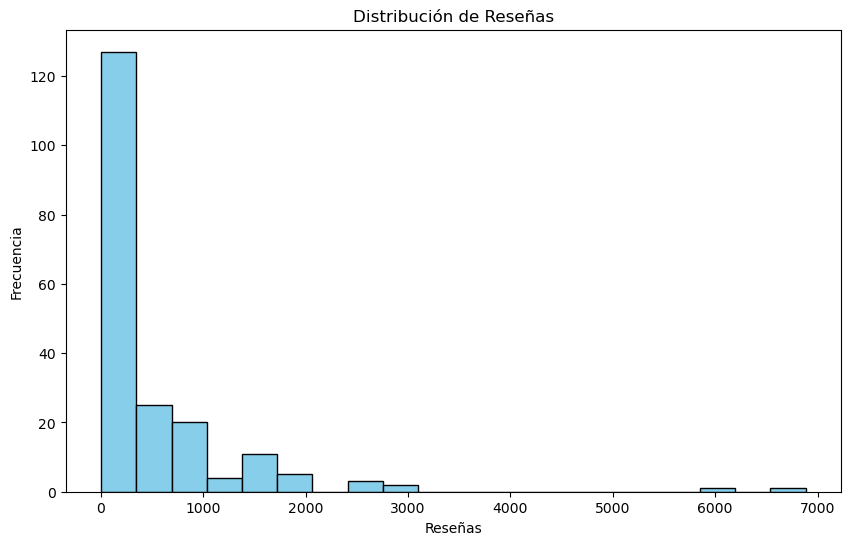

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df_res['review_count'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribución de Reseñas')
plt.xlabel('Reseñas')
plt.ylabel('Frecuencia')
plt.show()


In [ ]:
(df_res['review_count']).sort_values(ascending=False)

8      6884
32     5960
2      2994
1      2784
36     2573
       ... 
130       1
46        1
85        1
55        1
76        1
Name: review_count, Length: 199, dtype: int64

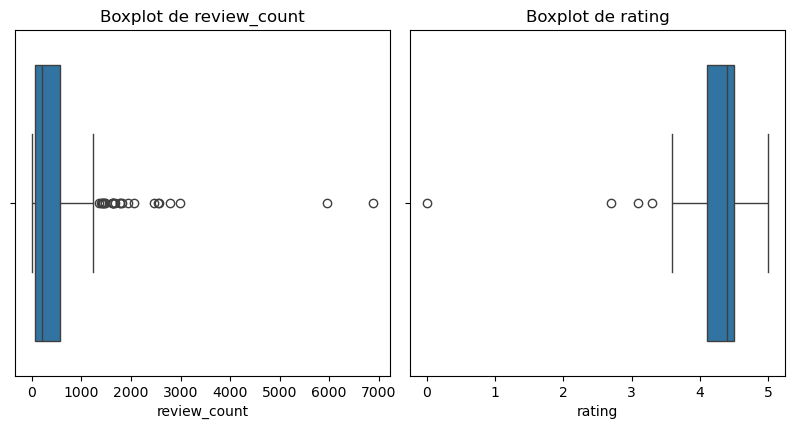

In [ ]:
num_cols = ['review_count', 'rating']
plt.figure(figsize=(12,8))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot de {col}')
plt.tight_layout()
plt.show()

Recordemos que el cuadrado representa entre el primer y tercer cuartil. En este caso, entre 72 y 574.
En el rating: es entre 4.1 y 4.5. Es decir, no hay mucho variabilidad.


In [ ]:
(df_res['review_count']).describe()

count     199.000000
mean      510.949749
std       841.592176
min         1.000000
25%        72.500000
50%       213.000000
75%       574.500000
max      6884.000000
Name: review_count, dtype: float64

In [ ]:
(df_res['rating']).describe()

count    199.000000
mean       4.338191
std        0.351402
min        2.700000
25%        4.100000
50%        4.400000
75%        4.500000
max        5.000000
Name: rating, dtype: float64

Modificación de variable  precio:

In [ ]:
# Recategorizo precio:

# Diccionario
price_map = {
    '$': 'Bajo',
    '$$': 'Medio',
    '$$$': 'Alto',
    '$$$$': 'Muy alto'
}

# columna categórica
df_res['cat_precio'] = df_res['price'].map(price_map)

# orden
orden_precio = ['Bajo', 'Medio', 'Alto', 'Muy alto']

# categoría ordenada
df_res['cat_precio'] = pd.Categorical(
    df_res['cat_precio'],
    categories=orden_precio,
    ordered=True
)

df_res['cat_precio'].value_counts()

cat_precio
Medio       92
Alto        21
Bajo        14
Muy alto     7
Name: count, dtype: int64

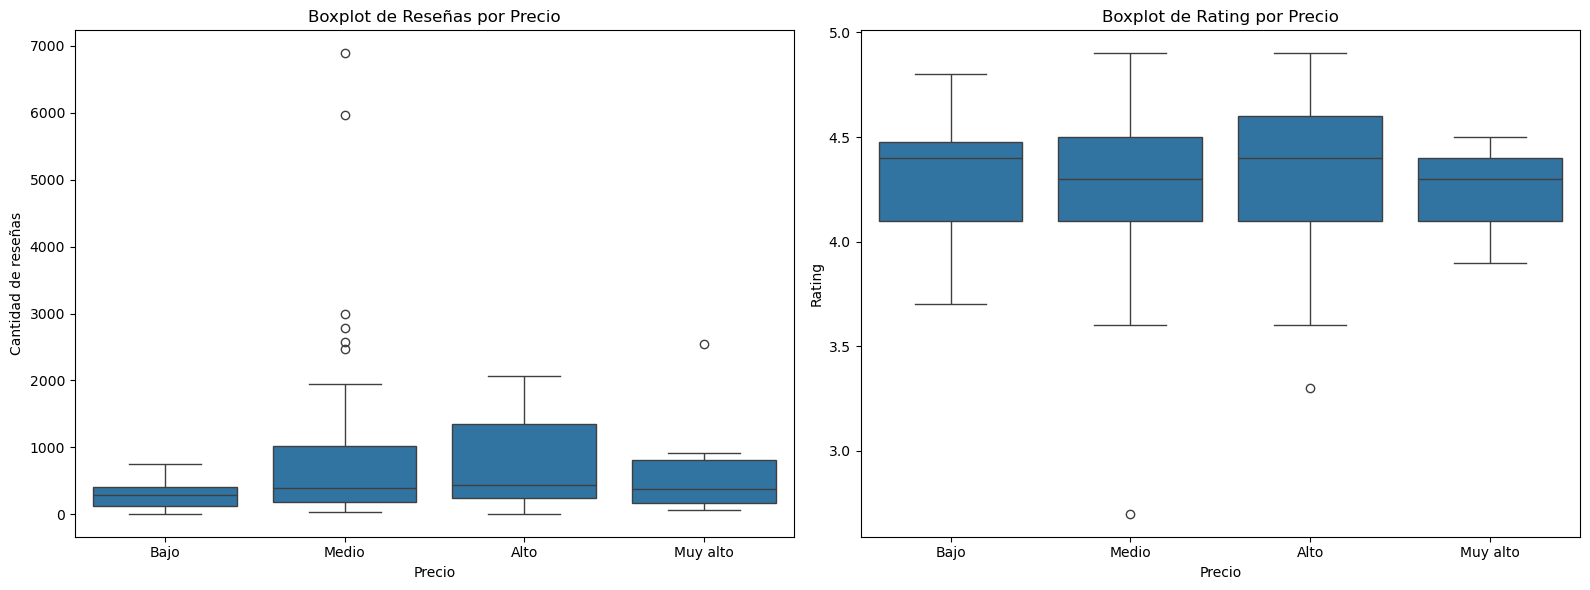

In [ ]:
# figura con 2 subplots (1 fila, 2 columnas)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Definir orden
orden_precio = ['Bajo', 'Medio', 'Alto', 'Muy alto']

# Boxplot 1: Review Count por precio
sns.boxplot(data=df_res, x='cat_precio', y='review_count',
            order=orden_precio, ax=axes[0])
axes[0].set_title('Boxplot de Reseñas por Precio')
axes[0].set_xlabel('Precio')
axes[0].set_ylabel('Cantidad de reseñas')

# Boxplot 2: Rating por precio
sns.boxplot(data=df_res, x='cat_precio', y='rating',
            order=orden_precio, ax=axes[1])
axes[1].set_title('Boxplot de Rating por Precio')
axes[1].set_xlabel('Precio')
axes[1].set_ylabel('Rating')

# Ajustamos diseño
plt.tight_layout()
plt.show()




Los casos con rango intercuartilico más amplios tanto en reseñas como en rating, son los de precios altos. Las reseñas de precios medios tienen más dispersión. Los de precios muy altos son los más homogéneos, tanto en cantidad de reseñas como en puntaje.

Es interesante que el rating no varía mucho según precio. Es decir, que evidentemente, en el putaje se tiene en cuenta la relación precio calidad.

### Elaboración de rating de mejores restaurant para recomendar.

1. Elaboración de rating ponderado.

In [ ]:
# Rating ajustado por cantidad de reviews:
# Inicialmene ibamos a usar un umbral mínimo de reviews, pero dado que los de categoría alta, tienen muy pocos casos, decidimos no considerarlo.

# Paso 1: logaritmo de review_count para achatar diferencias, es muy habitual para ingresos tambien:
df_res['review_log'] = np.log1p(df_res['review_count'])  # log(1 + v) para evitar log(0)

# Paso 2: normalizar entre 0 y 1
min_log = df_res['review_log'].min()
max_log = df_res['review_log'].max()
df_res['review_norm'] = (df_res['review_log'] - min_log) / (max_log - min_log)

# Paso 3: score ponderado usando review normalizada
media_rating = df_res['rating'].mean()
df_res['score'] = df_res['review_norm'] * df_res['rating'] + (1 - df_res['review_norm']) * media_rating

2. Revisión del rating ponderado

In [ ]:
# Revisión:

print(df_res[['rating', 'review_count', 'score']].sort_values('score', ascending=False).head())
print(df_res[['rating', 'review_count', 'score']].describe())
#print(df.groupby('cat_precio')['score'].mean())

print(df_res[['rating', 'review_count', 'score','cat_precio' ]].sort_values('review_count').head(50))

     rating  review_count     score
3       4.8          1811  4.724303
165     4.9           246  4.670438
147     4.9           108  4.614006
154     4.7           757  4.601976
38      4.7           719  4.599691
           rating  review_count       score
count  199.000000    199.000000  199.000000
mean     4.338191    510.949749    4.318403
std      0.351402    841.592176    0.176444
min      2.700000      1.000000    3.694764
25%      4.100000     72.500000    4.229916
50%      4.400000    213.000000    4.356396
75%      4.500000    574.500000    4.430703
max      5.000000   6884.000000    4.724303
     rating  review_count     score cat_precio
85      5.0             1  4.338191        NaN
76      5.0             1  4.338191        NaN
55      5.0             1  4.338191        NaN
130     5.0             1  4.338191        NaN
46      5.0             1  4.338191        NaN
178     5.0             2  4.371141        NaN
182     5.0             2  4.371141        NaN
134     5.0 

In [ ]:

percentil_10 = df_res['review_count'].quantile(0.1)
percentil_20 = df_res['review_count'].quantile(0.2)
min_score = df_res['score'].min()

print('P10: ', percentil_10)
print('P20: ', percentil_20)
print('Rating mínimo: ', min_score)


P10:  17.6
P20:  50.0
Rating mínimo:  3.6947642036526576


3.  Reajuste: nuevo rating:

No queremos incluir casos con muy pocas reseñas, o en todo caso bajarle el puntje, para que queden como última opción, cuando no tengamos casos de restaruant de determinada categoría de precios y comidas. En este dataset el percentil 20 es de 50 reseñas. El del percentil 10, 17 reseñas.
Ajustaremos nuevamente el score (rating ajustado por cantidad de reseñas) de esta forma: 
- si reseñas es menor o igual al percentil 10, no se recomienda en ningún caso: score = 0
- si reseñas está entre el percentil 11 y 20, se baja el puntaje a menos que el score mínimo. Esto es para que quede ordenada esta parte, y se pueda reocmendar si no hay otros casos de la misma categoría. 
- si reseñas es mayor al percentil 20, se usa el score. 

In [ ]:
# Función para ajustar calculo:

def calcular_rating_ponderado(row):
    if row['review_count'] <= percentil_10:  #si review_count <= percentil 10: score = 0
        return 0

    elif row['review_count'] <= percentil_20:
        # Escala lineal entre 0 y 1
        peso = (row['review_count'] - percentil_10) / (percentil_20 - percentil_10)

        # Escalamos entre 0 y min_score
        return peso * min_score

    else:
        # A partir del p20 usamos directamente el score original
        return row['score']


# Aplicamos
df_res['rating_ponderado'] = df_res.apply(calcular_rating_ponderado, axis=1)


4. Revisión de nuevo rating.

In [ ]:
print('P10: ', percentil_10)
print('P20: ', percentil_20)
print(df_res[['rating', 'review_count', 'score','cat_precio', 'rating_ponderado']].sort_values('review_count').head(50))
print(df_res[['rating', 'review_count', 'score', 'rating_ponderado']].describe())

P10:  17.6
P20:  50.0
     rating  review_count     score cat_precio  rating_ponderado
85      5.0             1  4.338191        NaN          0.000000
76      5.0             1  4.338191        NaN          0.000000
55      5.0             1  4.338191        NaN          0.000000
130     5.0             1  4.338191        NaN          0.000000
46      5.0             1  4.338191        NaN          0.000000
178     5.0             2  4.371141        NaN          0.000000
182     5.0             2  4.371141        NaN          0.000000
134     5.0             3  4.394519        NaN          0.000000
186     4.8             4  4.390150        NaN          0.000000
150     4.0             4  4.300140        NaN          0.000000
69      4.5             4  4.356396        NaN          0.000000
84      4.3             8  4.331138        NaN          0.000000
179     4.0             8  4.275732        NaN          0.000000
177     4.2            10  4.309264        NaN          0.000000
122

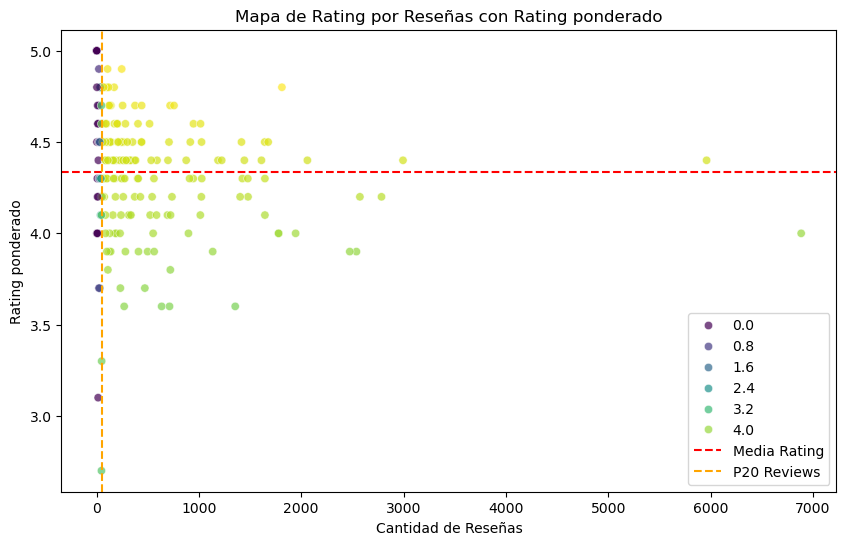

In [ ]:

plt.figure(figsize=(10, 6))

# Scatterplot con color según el score
sns.scatterplot(
    data=df_res,
    x='review_count',
    y='rating',
    hue='rating_ponderado',
    palette='viridis',
    sizes=(50, 400),  # escala de tamaño
    alpha=0.7
)

plt.axhline(df_res['rating'].mean(), color='red', linestyle='--', label='Media Rating')
plt.axvline(df_res['review_count'].quantile(0.2), color='orange', linestyle='--', label='P20 Reviews')

plt.title('Mapa de Rating por Reseñas con Rating ponderado')
plt.xlabel('Cantidad de Reseñas')
plt.ylabel('Rating ponderado')
plt.legend()
plt.show()


C:\Users\27267964837\AppData\Local\Temp\ipykernel_35128\1775421539.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


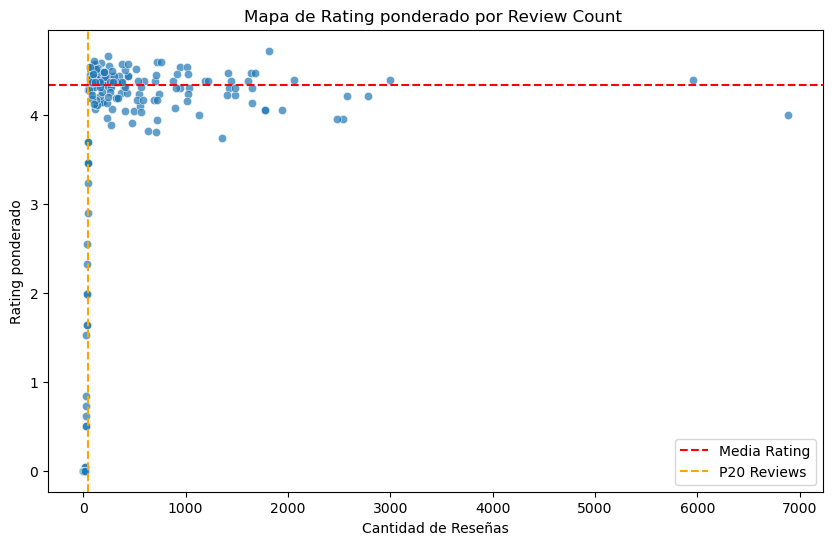

In [ ]:

plt.figure(figsize=(10, 6))

# Scatterplot con color según el score
sns.scatterplot(
    data=df_res,
    x='review_count',
    y='rating_ponderado',
    palette='viridis',
    sizes=(50, 400),  # escala de tamaño
    alpha=0.7
)

plt.axhline(df_res['rating'].mean(), color='red', linestyle='--', label='Media Rating')
plt.axvline(df_res['review_count'].quantile(0.2), color='orange', linestyle='--', label='P20 Reviews')

plt.title('Mapa de Rating ponderado por Review Count ')
plt.xlabel('Cantidad de Reseñas')
plt.ylabel('Rating ponderado')
plt.legend()
plt.show()

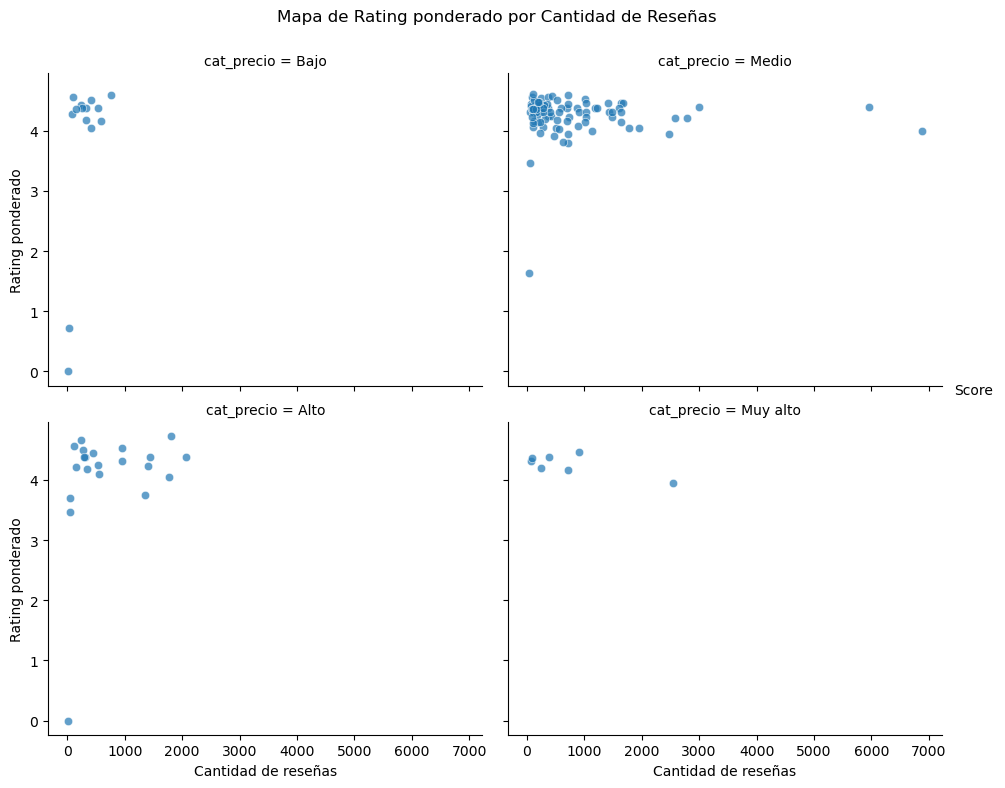

In [ ]:

# Definir orden de precios
orden = ['Bajo', 'Medio', 'Alto', 'Muy alto']

# Crear la figura con FacetGrid: 2 filas x 2 columnas
g = sns.FacetGrid(df_res, col='cat_precio', col_order= orden,
                  col_wrap=2, height=4, aspect=1.2)

# Agregar scatterplot en cada faceta
g.map_dataframe(
    sns.scatterplot,
    x='review_count',
    y='rating_ponderado',
    sizes=(30, 250),
    alpha=0.7
)

# Ajustes generales
g.set_axis_labels('Cantidad de reseñas', 'Rating ponderado')
#g.set_titles(col_template='{col_name}')
g.add_legend(title='Score')

plt.subplots_adjust(top=0.9)
g.fig.suptitle('Mapa de Rating ponderado por Cantidad de Reseñas')

plt.show()


## Categorías de restaurants:

In [ ]:
# Convertir strings en listas/dicts de verdad
df_res['categories'] = df_res['categories'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# 1) extraer los títulos de cada categoría
df_res['cat_titles'] = df_res['categories'].apply(lambda x: [d['title'] for d in x])

# 2) 'explotar' la lista en varias filas
df_long = df_res.explode('cat_titles')[['id', 'cat_titles']]

df_long['cat_titles'].unique()

array(['Asian Fusion', 'Steakhouses', 'Cocktail Bars', 'Mediterranean',
       'Italian', 'Spanish', 'Cuban', 'Bars', 'Venues & Event Spaces',
       'Seafood', 'American', 'Wine Bars', 'Desserts', 'Sports Bars',
       'New American', 'Lounges', 'Breakfast & Brunch', 'Cafes',
       'Coffee & Tea', 'Sandwiches', 'Sushi Bars', 'Argentine',
       'Bakeries', 'Butcher', 'Comfort Food', 'Juice Bars & Smoothies',
       'Korean', 'Mexican', 'Latin American', 'Greek', 'Lebanese',
       'New Mexican Cuisine', 'Tacos', 'Burgers', 'Pop-Up Restaurants',
       'Acai Bowls', 'Cajun/Creole', 'Polish', 'Modern European',
       'Peruvian', 'Southern', 'Puerto Rican', 'Middle Eastern', 'French',
       'Bubble Tea', 'Ramen', 'Live/Raw Food', 'Food Trucks', 'Barbeque',
       'Empanadas', 'Patisserie/Cake Shop', 'Tapas/Small Plates', 'Thai',
       'Nicaraguan', 'Portuguese', 'Jazz & Blues', 'Pop-up Shops',
       'Persian/Iranian', 'Gastropubs', 'Indian', 'Food Court', 'Arabic',
       'Chinese',

In [ ]:
df_res.head()

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,transactions,...,location.country,location.state,location.display_address,price,cat_precio,review_log,review_norm,score,rating_ponderado,cat_titles
0,K3ukx2e11xTRtYBU01dmrA,salty-flame-miami,Salty Flame,https://s3-media0.fl.yelpcdn.com/bphoto/_6wShT...,False,https://www.yelp.com/biz/salty-flame-miami?adj...,190,"[{'alias': 'asianfusion', 'title': 'Asian Fusi...",4.4,"['delivery', 'pickup']",...,US,FL,"['1414 Brickell Ave', 'Miami, FL 33131']",NaN,NaN,5.252273,0.559817,4.372793,4.372793,"[Asian Fusion, Steakhouses, Cocktail Bars]"
1,ix8ifP1jQM9ektdVAs19sQ,crazy-about-you-miami-3,Crazy About You,https://s3-media0.fl.yelpcdn.com/bphoto/vvQBoP...,False,https://www.yelp.com/biz/crazy-about-you-miami...,2784,"[{'alias': 'mediterranean', 'title': 'Mediterr...",4.2,"['delivery', 'restaurant_reservation']",...,US,FL,"['1155 Brickell Bay Dr', 'Ste 101', 'Miami, FL...",$$,Medio,7.932003,0.888863,4.215358,4.215358,"[Mediterranean, Italian, Spanish]"
2,UXHxLN3DcDGI57uDIfCuJA,olds-havana-cuban-bar-and-cocina-miami,Old's Havana Cuban Bar & Cocina,https://s3-media0.fl.yelpcdn.com/bphoto/OyMD-x...,False,https://www.yelp.com/biz/olds-havana-cuban-bar...,2994,"[{'alias': 'cuban', 'title': 'Cuban'}, {'alias...",4.4,"['restaurant_reservation', 'pickup']",...,US,FL,"['1442 SW 8th St', 'Miami, FL 33135']",$$,Medio,8.004700,0.897789,4.393682,4.393682,"[Cuban, Bars, Venues & Event Spaces]"
3,oxtMfBGmVNE18pFVuw7lFg,fratellino-coral-gables-2,Fratellino,https://s3-media0.fl.yelpcdn.com/bphoto/OPS9ib...,False,https://www.yelp.com/biz/fratellino-coral-gabl...,1811,"[{'alias': 'italian', 'title': 'Italian'}]",4.8,"['delivery', 'pickup']",...,US,FL,"['264 Miracle Mile', 'Coral Gables, FL 33134']",$$$,Alto,7.502186,0.836085,4.724303,4.724303,[Italian]
4,WqIBKxRUPXH3NqTViAHLxQ,bayshore-club-bar-and-grill-miami,Bayshore Club Bar & Grill,https://s3-media0.fl.yelpcdn.com/bphoto/B7tTbJ...,False,https://www.yelp.com/biz/bayshore-club-bar-and...,945,"[{'alias': 'seafood', 'title': 'Seafood'}, {'a...",4.3,[],...,US,FL,"['3391 Pan American Dr', 'Miami, FL 33133']",$$$,Alto,6.852243,0.756278,4.309308,4.309308,"[Seafood, American, Wine Bars]"


In [ ]:
col_sel = ['id', 'alias', 'name', 'review_count', 'categories', 'rating', 'transactions',
 'coordinates.latitude', 'coordinates.longitude', 'location.city', 'price',
 'cat_precio', 'score', 'rating_ponderado', 'cat_titles']

df_res.to_csv('yelp_restaurantes_miami_limpia.csv', columns=col_sel, index= False)